Here we are saving 360 degree views in a grid across the world, to compare familiarity when using Zernike Moments.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os.path
import sys
import errno

import numpy as np
import scipy as sp
import scipy.io as sio # To import Matlab stuff
import scipy.ndimage
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import cv2
from PIL import Image

In [3]:
from world_viewer import WorldViewer

This world contains tussoks and trees. For now they have both been coloured black

In [4]:
world_folder = '/data/treeworld/'
world_name = 'worldtrees1'
matlab_world  = sio.loadmat(world_folder + world_name + '.mat')

In [5]:
X = matlab_world['X']
Y = matlab_world['Y']
Z = matlab_world['Z']

Where we want to store saved images. World name is appended to this folder

In [6]:
image_folder = '../data/world_images'

In [7]:
# Read in images in grayscale
wv = WorldViewer(X=X,
                 Y=Y,
                 Z=Z,
                 c=None,
                 resolution=1,
                 hfov_deg=360.0,
                 v_max=np.pi/2,
                 v_min=-np.pi/12,
                 data_folder=image_folder,
                 world_name=world_name,
                 sky_colour='white',
                 ground_colour=(0.1, 0.1, 0.1, 1),
                 grass_colour='gray')

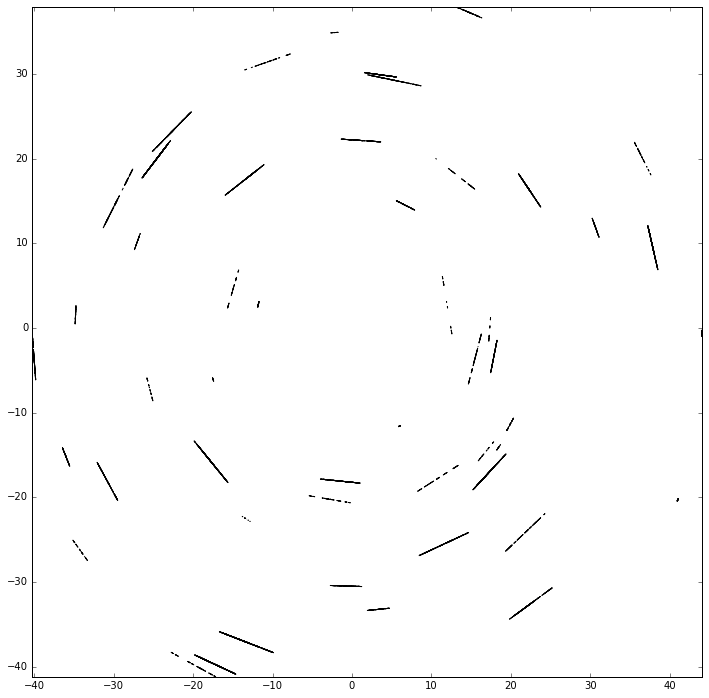

In [8]:
fig, ax = plt.subplots(figsize=(12,12))

# Add the world polygons (grass and trees)
verts = np.dstack((X, Y))
p = PolyCollection(verts)
ax.add_collection(p)

ax.set_xlim([np.min(X), np.max(X)])
ax.set_ylim([np.min(Y), np.max(Y)])
plt.show()

Choose the area that we are going to capture

In [ ]:
xmin = 0
xmax = 10

ymin = 0
ymax = 10

And the step size between images

In [ ]:
step_size = 0.1

This is a bit hacky. We added an offset to all the x and y values so that the file names would sort nicely

In [ ]:
xoffset = np.abs(xmin)
yoffset = np.abs(ymin)

Iterate through the grid taking an image at each location and saving it.

Todo: ! This is very expensive and we should probably check in the world_viewer class if a file already exists, then skip if it does. (would allow iteratively increasing the resolution of our sampling in a much nicer way.

In [ ]:
for x in np.arange(xmin, xmax+step_size, step_size):
    for y in np.arange(ymin, ymax+step_size, step_size):
        wv.save_view(x=x, y=y, th=0, xoffset=xoffset, yoffset=yoffset)

Go through all images and convert from cartesian to polar representation

In [ ]:
def cart2polar(x, y):
    phi = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return theta, phi

In [ ]:
directory = image_folder + '/' + world_name
file_names = sorted(glob.glob('%s/*.%s' % (directory, 'png')))
len(file_names)

Find the size of images by peeking a the first one.

In [ ]:
img = Image.open(file_names[0]) # Lazy so won't load into memory
w, h = img.size

Create a mapping from current coordinates to new ones.

In [ ]:
x_range = np.linspace (-1, 1, h*2) # We make the radius of our plot the same as the height of current images.
xx, yy = np.meshgrid(x_range, x_range)
theta, phi = cart2polar(xx, yy)
theta = (theta / np.max(theta) + 1) * (w-1)/2
phi = phi * (h-1)
coords = np.vstack((theta.flatten(), phi.flatten()))

Remap each image and save in a subfolder 'w' (for 'wrapped')

In [ ]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [ ]:
make_sure_path_exists(directory + "/w/")

In [ ]:
for file_name in file_names:
    new_file = directory + "/w/" + os.path.split(file_name)[1]
    
    if os.path.isfile(new_file) is False:
        I = cv2.imread(file_name, 0)
        I_wrapped = sp.ndimage.map_coordinates(I.T, coords, order=1).reshape((h*2, h*2))
        cv2.imwrite(new_file, I_wrapped)

Image looks something like this

In [ ]:
plt.imshow(I_wrapped, cmap='gray')